In [59]:
import numpy as np
import eazy

import tqdm

import os

from astropy.table import vstack, Table
from astropy import units as u

import matplotlib.pyplot as plt

## Define filter filtes

In [3]:
# Top-hat like filter transmission curve
def tophat_trans(x, center=0, fwhm=1, smoothness=0.2):

    from scipy.special import erf, erfc
    
    t_left  = erfc(+((2*(x-center)/fwhm)-1)/smoothness)/2 
    t_right = erfc(-((2*(x-center)/fwhm)+1)/smoothness)/2
    
    return (t_left*t_right)

In [19]:
lambda_7ds = np.arange(4000., 9000., 250)
# flux_7ds = np.zeros_like(lambda_7ds)

filters_original = {}

for ii, wl_cen in enumerate(lambda_7ds):
    fwhm = 250
    wave_lvf = np.linspace(0.1, 1.0, 1001)
    resp_lvf = tophat_trans(wave_lvf, center=wl_cen/1e4, fwhm=fwhm/1e4)
    
    filters_original[f'wave_{int(wl_cen):d}'] = wave_lvf
    filters_original[f'resp_{int(wl_cen):d}'] = resp_lvf

In [20]:
# QE table of Gemini GMOS-N Hamamatsu CCD
T_qe = Table.read('http://www.gemini.edu/sciops/instruments/gmos/gmos_n_ccd_hamamatsu_sc.txt', 
                  format='ascii.no_header', names=('wavelength', 'QE'))
T_qe['wavelength'] = T_qe['wavelength'].astype(float) * 1e-3
T_qe['wavelength'].unit = u.um
T_qe['wavelength'].format = '8.4f'


eff_mirrors = (0.92)**2  # Aluminium coating, 2 mirrors
eff_optics = 0.95        # Camera optics 
eff_LVF = 0.90           # LVF peak transmission (filter top transmission)
eff_fpa = 0.80           # Detector Quantum Efficiency (QE), nominal value

lambda_mid = 0.6
eff_fpa = np.interp(lambda_mid, T_qe['wavelength']/1000, T_qe['QE'])

eff_opt   = eff_mirrors * eff_optics * eff_LVF
eff_total = eff_opt * eff_fpa

sky_tbl = Table.read('./22A_special_lecture/data/skytable.fits')
from scipy.ndimage import gaussian_filter
trans_smooth = gaussian_filter(sky_tbl['trans'], 10)

In [24]:
filters_corrected = {}

for ii, wl_cen in enumerate(lambda_7ds):
    
    wave_lvf = filters_original[f'wave_{int(wl_cen):d}']
    resp_lvf = filters_original[f'resp_{int(wl_cen):d}']
    
    
    resp_sys = resp_lvf.copy()
    intp_qe = np.interp(wave_lvf, T_qe['wavelength'], T_qe['QE'])
    intp_trans = np.interp(wave_lvf, sky_tbl['lam']*1e-3, trans_smooth)
    
    resp_sys = resp_sys * intp_qe * intp_trans 
    resp_sys *= eff_mirrors * eff_optics
    
    filters_corrected[f'resp_{int(wl_cen):d}'] = resp_sys
    filters_corrected[f'wave_{int(wl_cen):d}'] = wave_lvf
    

(0.3, 1.0)

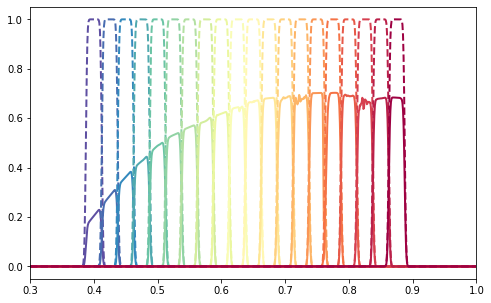

In [25]:
fig, ax = plt.subplots(figsize = (8, 5))

colors = plt.cm.Spectral(np.linspace(1, 0, 20))
for ii, wl_cen in enumerate(lambda_7ds):
    
    wave_ori = filters_original[f'wave_{int(wl_cen):d}']
    resp_ori = filters_original[f'resp_{int(wl_cen):d}']
    
        
    wave_cor = filters_corrected[f'wave_{int(wl_cen):d}']
    resp_cor = filters_corrected[f'resp_{int(wl_cen):d}']
    
    ax.plot(wave_ori, resp_ori, color = colors[ii], linewidth = 2, linestyle = '--')
    ax.plot(wave_cor, resp_cor, color = colors[ii], linewidth = 2)
    
ax.set_xlim(0.3, 1)



In [31]:
# filters_corrected

fsets = ''

for ii, wl_cen in enumerate(lambda_7ds):
    
    wave = filters_corrected[f'wave_{int(wl_cen):d}'] * 1e4
    resp = filters_corrected[f'resp_{int(wl_cen):d}']
        
    fset = eazy.filters.FilterDefinition(wave = wave, throughput = resp, name = f'wave_{int(wl_cen):d}')
    
    fsets = fsets + fset.for_filter_file() + '\n'

In [34]:
with open('./output/sevends.FILTER.RES', 'w') as f:
    f.write(fsets)

## create a table for running eazy

In [37]:
plates = os.listdir('/data6/SDSSspec')
plates.sort()

plates = plates[:-1]
print(f'total {len(plates)} plates')

total 3809 plates


In [57]:
for pl in tqdm.tqdm(plates[:100]):
    
#     spec_path = "/data6/SDSSspec/" + pl + "/"
    tbl_path = "/data6/SDSSspec_sup/" + pl + "/"
        
    specphot = Table.read(tbl_path + 'specPhotoAll_' + pl + '.csv')
    synphot = Table.read(tbl_path + 'synphot.csv')
    
    idx_matched = [np.where((specphot['mjd'] == synphot['mjd'][i]) & (specphot['fiberID'] == synphot['fiberid'][i]))[0][0] for i in range(len(synphot))]
    specphot= specphot[idx_matched]
    
    # add spec-z
    synphot['z_spec'] = specphot['z']
    
    #add flux error
    
    for ii, wl_cen in enumerate(lambda_7ds):
        synphot[f'flux_err_{int(wl_cen):d}'] = synphot[f'flux_{int(wl_cen):d}'] * 0.05
#     syn
    synphot.write(tbl_path + 'synphot_eazy.csv', overwrite = True)

100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


In [60]:
tbl_final = None

for pl in tqdm.tqdm(plates[:100]):
    synphot = Table.read(tbl_path + 'synphot_eazy.csv')
    
    if pl == plates[0]:
        tbl_final = synphot
        continue
    
    tbl_final = vstack([tbl_final, synphot])

100%|██████████| 100/100 [00:02<00:00, 36.25it/s]


In [90]:
# header = '#ID'
header = '#'

for name in tbl_final.keys()[3:]:
    header += '\t' + name 
    
header += '\n'

In [91]:
values = ''

for i in range(len(tbl_final)):
    
    val = ''
    
    for col in tbl_final.keys()[3:]:
        
        val += f'{tbl_final[i][col]:.5E}' + '\t'
        
        
    val += '\n'
    
    values += val
    


In [92]:
############################### save output file
with open('./output/temp.cat', 'w') as f:
    f.write(header + values)

In [69]:
tbl_final.write('./output/temp.dat', overwrite = True, format = 'ascii')

(array([  700.,   400.,   400.,   700.,   500.,   500.,  2100.,  9500.,
        24900., 16000.,  7000.,  2500.,  1200.,   900.,   500.,   300.,
          200.,   200.,     0.,   100.]),
 array([0.       , 0.0965748, 0.1931496, 0.2897244, 0.3862992, 0.482874 ,
        0.5794488, 0.6760236, 0.7725984, 0.8691732, 0.965748 , 1.0623228,
        1.1588976, 1.2554724, 1.3520472, 1.448622 , 1.5451968, 1.6417716,
        1.7383464, 1.8349212, 1.931496 ]),
 <BarContainer object of 20 artists>)

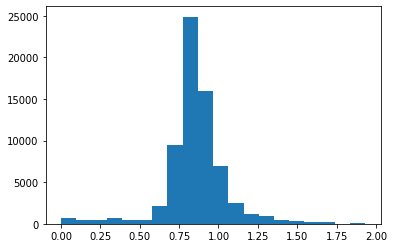

In [64]:
plt.hist(tbl_final['z_spec'], bins = 20)